# <center> Recommender Systems </center>
### <center> Week 2. Intro to MF and collaborative filteting (ALS) </center>

### Matrix factorization

<img src='images/mf.png' height=700 width=700>

1) Хотим ли восстановить исходную матрицу со всеми нулями при перемножении матриц P и Q? <br>
2) Что важнее - сама оценка скалярного произведения или порядок между оценками?

### SVD

<img src='svd.png' height=500 width=500>

SVD, помимо скалярного произведения, включает еще смещения по пользователю $b_u$ и объекту $b_i$. Предполагается, что смещения пользователей отражают тенденцию некоторых пользователей оценивать товары выше (или ниже) среднего. То же самое касается товаров: некоторые товары обычно оцениваются выше, чем некоторые другие. Модель SVD тогда выглядит следующим образом:

$$\hat r_{u,i} = \mu + b_u + b_i + q_{i}^{T}p_{u},$$

где $\mu$ - глобальное среднее по всем оценкам в данных. Тогда задача оптимизации сводится к:

$$ \sum(r_{u,i} - \hat r_{u,i}) ^ 2 +     \lambda(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2),$$

где $\lambda$ - параметр регуляризации.

Оптимизация через стохастический градиентный спуск:

$$b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u)$$
$$b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i)$$  
$$p_u \leftarrow p_u + \gamma (e_{ui} \cdot q_i - \lambda p_u)$$
$$q_i \leftarrow q_i + \gamma (e_{ui} \cdot p_u - \lambda q_i),$$

где $\gamma$ - это learning rate, <br>
$e_{ui} =  r_{ui} - \hat r_{u,i} = r_{u,i} - (\mu + b_u + b_i + q_{i}^{T}p_{u})$ ошибка алгоритма на паре $(u, i)$.

Сколько компонент брать? 

Мы не хотим получить точно такую же матрицу как и была у нас в самом начале (overfitted), но нам и не подойдет вариант с новой матрицей, где значения сильно разнятся с исходными (underfitted).

Какие есть способы сравнить два набора данных? Можно выбрать разные метрики, чтобы проанализировать ошибку с разных сторон рассмотрения. Например, **MSE** и **MAE**.

![%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%202021-09-21%20%D0%B2%2009.10.56.png](attachment:%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA%20%D1%8D%D0%BA%D1%80%D0%B0%D0%BD%D0%B0%202021-09-21%20%D0%B2%2009.10.56.png )

На третьей компоненте и до пятой величина MSE практически не меняется, по этому остановимся на трёх компонентах.

Мы можем добавить коэффициент объясненной дисперсии и разреженность.


**Explained variance ratio (EVR)** — коэффициент объясненной дисперсии. 

**Sparsity** — разреженность данных, оценить которую можно отношением количества элементов больше 0 к количеству всех элементов.

Как бы вы проинтерпретировали этот график?

<img src='svd2.png' height=700 width=700>
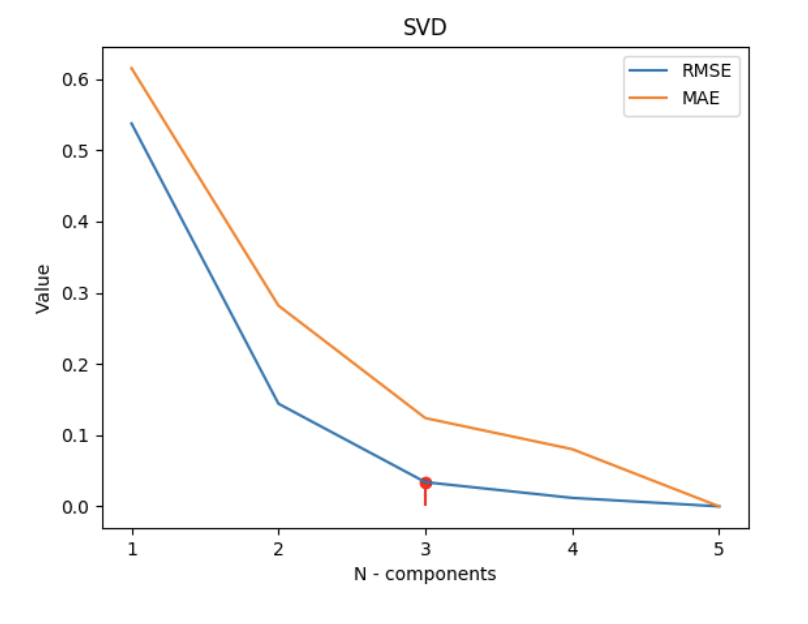

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD as SVD
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import mean_squared_error as mse


data = np.array([[0,1,0,1,2,2],
              [2,3,1,1,2,2],
              [1,1,1,0,1,1],
              [0,2,3,4,1,1],
              [0,0,0,0,1,0]])

data = pd.DataFrame(V, index = ('Овощи', 'Фрукты', 'Сладости', 'Хлеб', 'Кофе'),
                columns = ('Миша', 'Маша' ,'Рома', 'Дима', 'Витя', 'Вова'))

def reconstruct(model, data):
#input: model - sklearn model, data - pandas DataFrame
#returns pandas DataFrame of reconstructed matrix
    model.fit(data)
    W = model.transform(data)
    H = model.components_
    reconstructed = pd.DataFrame(np.round(np.dot(W, H), 2), columns=data.columns, index=data.index)
    # next line use in case of SVD or PCA decomposition to substitute negative elements for zeros
    # reconstructed[reconstructed < 0] = 0
    new_data = []
    # interpolation of reconstructed matrix to range [0,1]
    for i in range(0, reconstructed.shape[0]):
        r = reconstructed.loc[reconstructed.index[i]]
        rd = np.interp(r, (r.min(), r.max()), (0, +1))
        new_data.append(rd)
    interpolated = pd.DataFrame(np.round(new_data, 2), index=reconstructed.index, columns=reconstructed.columns)
    return reconstructed , interpolated

def sparsity(data):
    return 1.0 - np.count_nonzero(data) / data.size


def rel_spars(data):
    return 1 - (sparsity(data) / sparsity(V))


def evaluate_plot(model, data):
    EVS = []
    MSE = []
    MAE = []
    SPARS = []
    ks = [1, 2, 3, 4, 5]
    for k in ks:
        MAE.append(mae(data, reconstruct(model(n_components=k), data)[0]))
        MSE.append((mse(data, reconstruct(model(n_components=k), data)[0])))
        EVS.append(evs(data, reconstruct(model(n_components=k), data)[0]))
        SPARS.append(rel_spars(reconstruct(model(n_components=k), data)[0]))
    plt.xlabel('N - components')
    plt.ylabel('Value')
    plt.plot(MSE)
    plt.plot(MAE)
    plt.plot(EVS)
    plt.plot(SPARS)
    METRIC = np.round(MSE, 1)
    for i in range(0, len((METRIC))):
        if METRIC[i] == METRIC[i + 1]:
            plt.scatter(i, MSE[i], c='red')
            plt.scatter(i, EVS[i], c='red')
            plt.scatter(i, SPARS[i], c='green')
            plt.text(i, EVS[i] + 0.01, str(np.round(EVS[i], 3)))
            plt.text(i, SPARS[i] + 0.01, str(np.round(SPARS[i], 3)))
            plt.vlines(i, 0, 1, colors='red')
            break
    plt.legend(('RMSE', 'MAE', 'EVS', 'SPARSITY'), loc='best')
    plt.xticks([0, 1, 2, 3, 4], ks)
    plt.show()
    
    
model = SVD()
#model = PCA
#model = SVD

evaluate_plot(model, V)
print(reconstruct(model, V)[0]) #reconstructed
print(reconstruct(model, V)[1]) #interpolated

Пара слов про "бесплатную классификацию без учителя"

<img src='3.png' height=500 width=500>
<img src='2.png' height=500 width=500>

<img src='1.png' height=500 width=500>

### ALS (Alternative Least Squares)


**Оригинальная статья (для explicit feedback):**

ALS explicit Scalable Collaborative Filtering with Jointly Derived Neighborhood
Interpolation Weights https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4470228&casa_token=kI6K36JVhX0AAAAA:BFml2zsf_-9q3W55AH4twifWcCgAWHqpzGH9cRGzB_w2v1I1-VLFbcT6KkZbZUguK55uZKGc2tqTgQ&tag=1

**Статья для implicit данных:**

Collaborative Filtering for Implicit Feedback Datasets http://yifanhu.net/PUB/cf.pdf

**Особенности:**

1. Нет явных позитивных и отрицательных оценок. <br>
2. Шум в данных.  <br>
3. Свои метрики ранжирования для оценки implicit feedback. Если в explicit $r_ui$ - это оценки предпочтений пользователя, то в implicit - это степень уверенности. <br>
 
 
Формально, если есть $n$ пользователей и $m$ элементов, нам дается матрица $R^{n × m}$, в которой
$r_{u, i}$ – рейтинг объекта $i$ пользователя $u$. В матрице $R$ много пропущенных записей, указывающих
на ненаблюдаемые оценки. 


В матричной факторизации мы фиксируем относительно небольшое число $k$
(например, $k ≈ 10$) и суммируем каждого пользователя $u$ с $k$-мерным вектором $x_u$, а каждый элемент $i$-с
$k$-мерным вектором $y_i$. Эти векторы называются факторами. Затем, чтобы предсказать рейтинг пользователя $u$
для элемента $i$, мы просто прогнозируем $r_{ui} ≈ x^T_{u} y_i$. Это можно представить в виде матрицы: пусть $x_1, . . . , x_n \in R^ k$ - факторы для пользователей, а $y_1, . .., y_m \in R^k$ - факторы для объектов. Затем матрица пользователей $X$ размера $k × n$ и матрица элементов $Y$ размера $k × m$ определяются с помощью:

<img src='33.png' width=700 height=500>

Затем наша цель состоит в том, чтобы оценить полную матрицу рейтингов $R ≈ X^T Y$ .


Мы можем переформулировать эту задачу как задачу оптимизации, в которой мы стремимся минимизировать целевую функцию и найти
оптимальные $X$ и $Y$. В частности, мы стремимся минимизировать ошибку наименьших квадратов наблюдаемых оценок
(и упорядочить):

<img src='als_loss.png' width=700 height=500>

Для implicit feedback:

<img src='als_imp.png' width=600 height=600>
<img src='als_sol.png' width=500 height=400>


В статье переопределяются значения $r_{ui}$ и $p_{ui}$. Наш $r_{ui}$ - это сама оценка из наблюдения. Например, описывается соотношением просмотренных фильмов. И с этого момента у вас есть плотная метрика, состоящая из нулевых значений, которые ранее были отмечены как отсутствующие. $p_{ui}$ указывает на предпочтения пользователя U, что является бинаризацией $r_{ui}$. При этом, у нас будут разные уровни доверия также среди элементов, которые, как указано, являются предпочтительными для пользователя. В целом, по мере роста $r_ui$ у нас появляется все больше признаков того, что пользователю действительно нравится товар. Следовательно, мы вводим набор переменных, $c_ui$, которые измеряют нашу уверенность в наблюдении за $p_ui$. Чтобы учесть уверенность, вам нужно добавить $c_{ui}$. Чем больше значение наблюдения за пользовательским элементом, тем больше вы уверены в этом значении.

<img src='notations.png' width=500 height=500>

Таким образом, у нас есть некоторая минимальная уверенность в $p_ui$ для каждой пары пользовательских элементов, но по мере того, как мы наблюдаем больше положительных предпочтений по паре пользователь-объект, наша уверенность в $p_ui$ = 1 соответственно возрастает. Скорость увеличения регулируется константой $\alpha$. В наших экспериментах было установлено, что установка $\alpha $= 40 дает хорошие результаты.

Итеративное обновление:

<img src='als.png' width=700 height=500>

Для одной машины мы можем проанализировать вычислительную стоимость этого алгоритма. Обновление каждого $x_u$ будет стоить $O(n_uk^2 + k^3)$, где $n_u$ - количество элементов, оцененных пользователем $u$, и аналогично обновление каждого $y_i$ будет стоить $O(n_ik^2 + k^3)$, где $n_i$-количество пользователей, оценивших элемент $i$. После того как мы вычислили матрицы $X$ и $Y$ , есть несколько способов сделать прогноз. Первый - сделать то, что обсуждалось ранее, а именно просто предсказать $r_{ui} ≈ x^T_u y_i$ для каждого пользователя $u$ и элемента $i$. Этот подход будет стоить $O(nmk)$, если мы хотим оценить каждую пару пользовательских элементов. Однако этот подход является непомерно дорогим для большинства реальных наборов данных. Второй (и более целостный) подход заключается в использовании $x_u$ и $y_i$ в качестве функций в другом алгоритме обучения, объединяя эти функции с другими, которые имеют отношение к задаче прогнозирования.

Теперь рассмотрим iALS - implicit ALS по второй статьей, которая более известна и чаще используется на практике, потому что implicit данных гораздо больше. 

Советую посмотреть, как считается ALS при работе с дистрибутивными вычислениями (в зависимости от метода: join, broadcast). Так же, есть стриминг ALS. Это когда мы предполагаем, что данные рейтингов $r_ui$ передаются потоком, и что матрицы коэффициентов $X$, $Y$ помещаются в память каждой машины. Мы предполагаем, что поток смешан (shuffled) и мы можем использовать стохастический градиентный спуск(SGD)
чтобы обновить матрицы коэффициентов X, Y. 
<img src='als_st.png' width=500 height=500>